# Principal Component Analysis
Author: Kim Hazed Delfino

## Imports

In [38]:
import pandas as pd
import numpy as np
# lib for visuals
import matplotlib.pyplot as plt
import seaborn as sns
# Necessary libraries 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay

## Load The Data


In [39]:
path = r"C:\Users\kdelfino\Documents\GitHub\Kmean\cust_seg.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 1   Customer Id      850 non-null    int64  
 2   Age              850 non-null    int64  
 3   Edu              850 non-null    int64  
 4   Years Employed   850 non-null    int64  
 5   Income           850 non-null    int64  
 6   Card Debt        850 non-null    float64
 7   Other Debt       850 non-null    float64
 8   Defaulted        700 non-null    float64
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 66.5 KB


In [41]:
df.head()

,Unnamed: 0,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [42]:
# Check for Missing Values
df.isna().sum()

Unnamed: 0           0
Customer Id          0
Age                  0
Edu                  0
Years Employed       0
Income               0
Card Debt            0
Other Debt           0
Defaulted          150
DebtIncomeRatio      0
dtype: int64

- Looks like we have some missing values on `Defaulted` feature, we need to look into it futher to identify the best strategy on how to handle these missing values

In [43]:
df["Unnamed: 0"].nunique()

850

In [44]:
df["Customer Id"].nunique()

850

- Dropping `Unnamed` and `Customer ID` features since they're all unigue and do night provide any commonities that could help clustering algorithm 

In [45]:
# Drop Irrelevant Features
df.drop(columns=["Unnamed: 0", "Customer Id"], inplace=True)

In [46]:
# Double Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 53.2 KB


### Distribution using Histogram

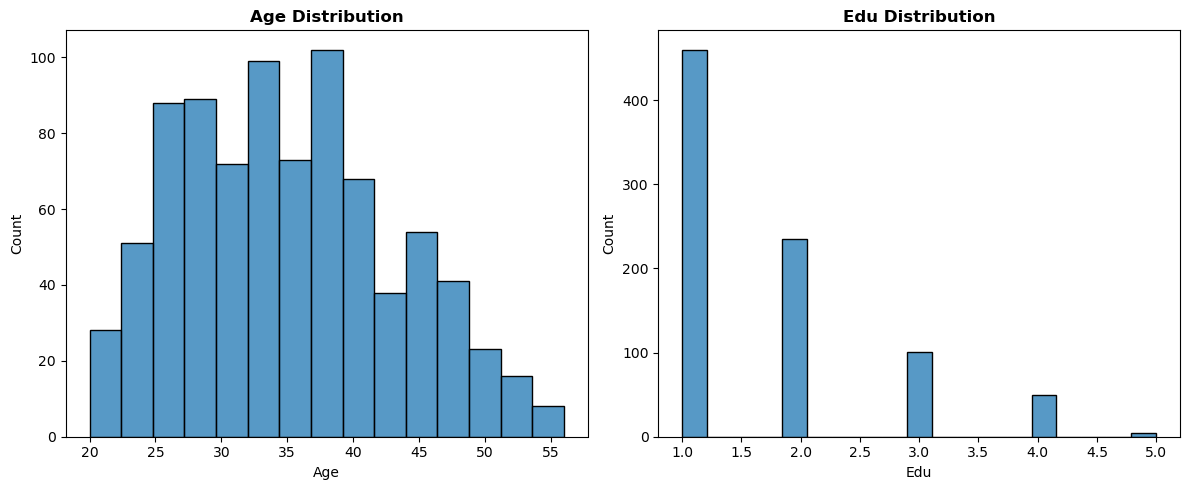

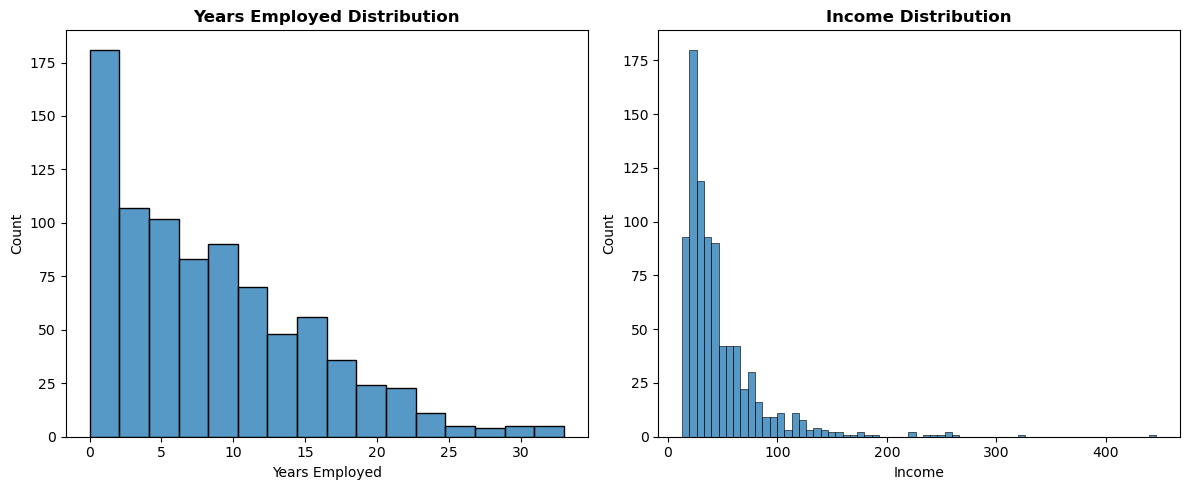

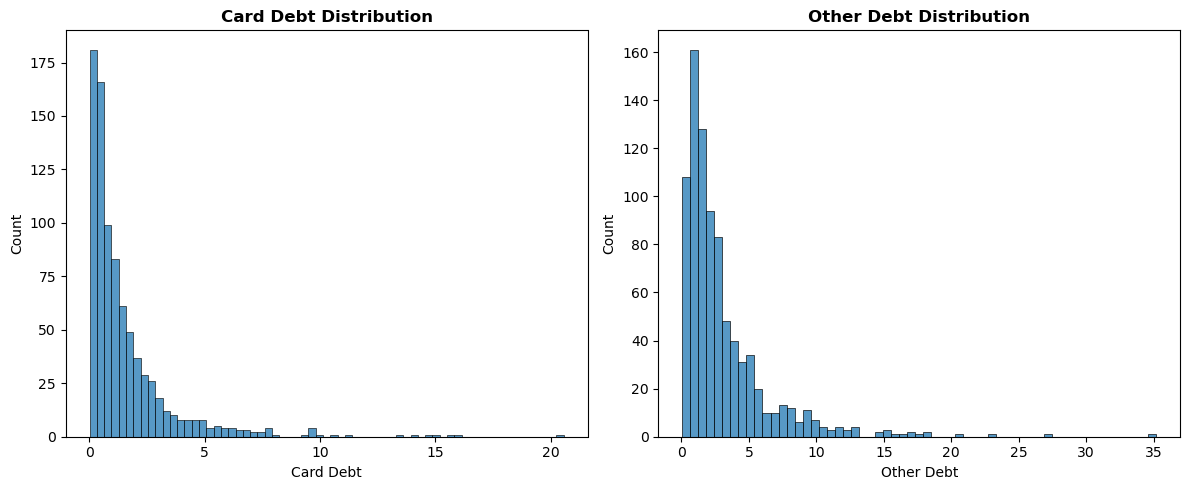

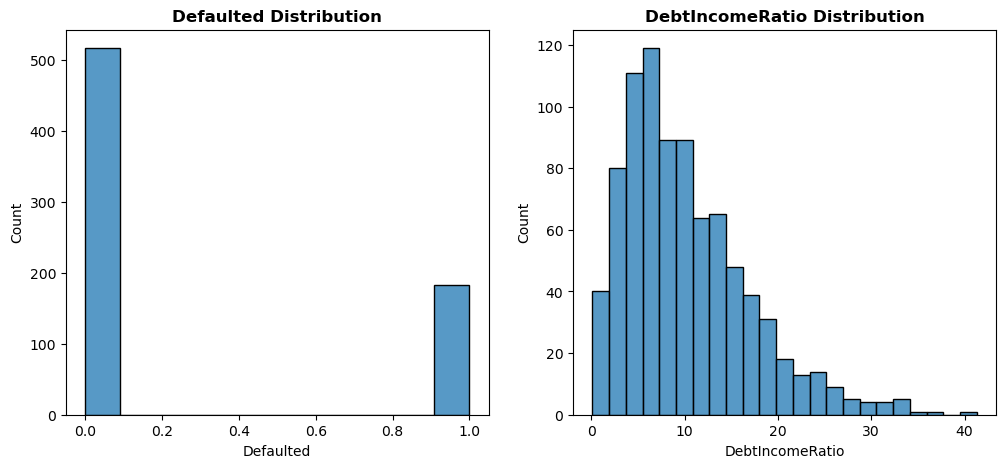

In [47]:
col_ax = 0
row_limit = 3
counter = 0
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
# Iterate to all features and display Historgram
for col in df.columns:
    # Set Historgram 
    ax=sns.histplot(data=df, x=col, ax=axes[col_ax])
    axes[col_ax].set_title(col+" Distribution", fontweight="bold")
    
    # Display every 2 cols and set new fig
    if col_ax == 1 and counter != row_limit:
        fig.tight_layout()
        fig, axes = plt.subplots(ncols=2, figsize=(12,5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1

- Here we can see the `Distributions` for all features in our dataset
- there are no impossible or questionable values in our dataset 

In [48]:
df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
457,34,1,4,28,1.058,1.574,NaN,9.4
3,29,2,4,19,0.681,0.516,0.0,6.3
509,29,2,1,29,2.330,3.818,1.0,21.2
652,40,3,16,116,1.614,12.422,0.0,12.1
75,33,1,5,18,0.985,1.337,0.0,12.9


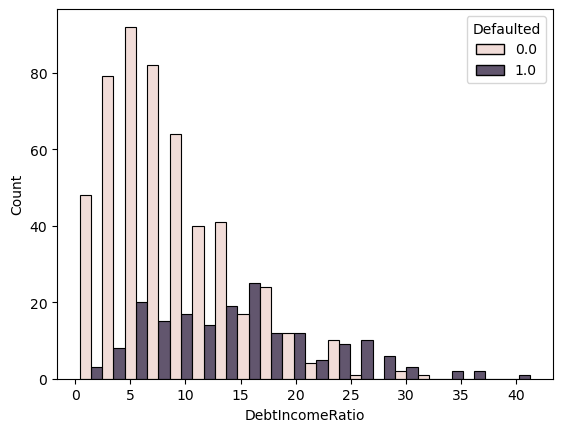

In [49]:
# Display hist for DebtIncomeRation and compare Defaulted 
sns.histplot(data=df, x="DebtIncomeRatio", hue="Defaulted", multiple="dodge");

- There's no clear commonality that would separate Defaulted vs Non-defaulted customers in terms of `DTI (DebtIncomeRatio)`, was hoping to see a fine line where we can easily distinguish defaulted customers based on DTI to help identify the missing values in Defaulted relative to DTI

- that being said , I think the best imputation strategy is to use a `classification model` to predict the missing values in our dataset , other option would be to use `Mode` imputation strategy since it's a categorical feature

### Using `Classification model` to predict missing value in `Defaulted` column

In [50]:
# Create new df without the missing values for training set
train_df = df.dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              700 non-null    int64  
 1   Edu              700 non-null    int64  
 2   Years Employed   700 non-null    int64  
 3   Income           700 non-null    int64  
 4   Card Debt        700 non-null    float64
 5   Other Debt       700 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 49.2 KB


In [51]:
# Create df for missing values that we will use for testing set
test_df = df[df["Defaulted"].isna()]
test_df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
825,32,2,12,116,4.027,2.585,NaN,5.7
630,51,4,15,26,2.012,1.524,NaN,13.6
233,23,1,6,15,1.375,0.530,NaN,12.7
788,33,2,8,27,1.646,1.000,NaN,9.8
376,29,2,9,30,3.646,2.864,NaN,21.7


In [52]:
# Split feature matrices and target vector for train set
X_train = train_df.drop(columns="Defaulted")
y_train = train_df["Defaulted"]

# Split feature matrices and target vector for test set
X_test = test_df.drop(columns="Defaulted")
y_pred = test_df["Defaulted"]

In [53]:
# Import Classification model
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf = RandomForestClassifier(random_state=42)

In [54]:
# Fit the model on train set 
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [55]:
# Predict train and test sets
rf_train_pred = rf.predict(X_train)

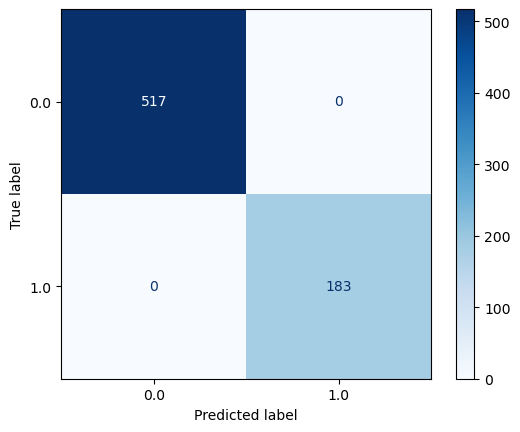

In [56]:
# Check model performance using Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, 
                                        rf_train_pred,
                                        cmap="Blues",
                                        normalize=None);





- Here we can see that our model is accurately predicting values in our target vector

In [57]:
# Replace missing values in y_test using X_test predictions
y_pred = rf.predict(X_test)
y_pred

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [58]:
# Import warning filter to remove warning when adding new column to df
import warnings
warnings.filterwarnings("ignore")

In [59]:
# Combine our model prediction to test_df 
test_df["prediction"] = y_pred
test_df

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,prediction
5,40,1,23,81,0.998,7.831,NaN,10.9,0.0
8,26,1,5,18,0.575,2.215,NaN,15.5,0.0
11,34,2,9,40,0.374,0.266,NaN,1.6,0.0
13,46,1,6,30,1.415,3.865,NaN,17.6,0.0
15,24,1,1,16,0.185,1.287,NaN,9.2,1.0
...,...,...,...,...,...,...,...,...,...
818,35,2,0,35,2.383,1.957,NaN,12.4,0.0
820,37,1,4,24,0.419,2.989,NaN,14.2,0.0
825,32,2,12,116,4.027,2.585,NaN,5.7,0.0
835,21,3,0,41,2.367,5.628,NaN,19.5,1.0


In [60]:
# Drop the missing value feature
test_df.drop(columns="Defaulted", inplace=True)

In [61]:
# Replace the column name prediction back to Defaulted
test_df.rename(columns={"prediction":"Defaulted"},inplace=True)

In [62]:
# Double check our test_df 
test_df.head()

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,DebtIncomeRatio,Defaulted
5,40,1,23,81,0.998,7.831,10.9,0.0
8,26,1,5,18,0.575,2.215,15.5,0.0
11,34,2,9,40,0.374,0.266,1.6,0.0
13,46,1,6,30,1.415,3.865,17.6,0.0
15,24,1,1,16,0.185,1.287,9.2,1.0


In [63]:
# Combine Train and test DataFrame back together into a new df
cleaned_df = pd.concat([train_df,test_df])

In [64]:
# Triple check new df 
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 850 entries, 0 to 845
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              850 non-null    int64  
 1   Edu              850 non-null    int64  
 2   Years Employed   850 non-null    int64  
 3   Income           850 non-null    int64  
 4   Card Debt        850 non-null    float64
 5   Other Debt       850 non-null    float64
 6   Defaulted        850 non-null    float64
 7   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 59.8 KB


In [65]:
cleaned_df.sample(5)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
212,37,1,9,57,1.357,1.778,0.0,5.5
54,29,3,5,70,3.176,10.754,1.0,19.9
284,48,1,22,100,3.704,5.396,0.0,9.1
461,41,3,17,176,11.359,5.009,1.0,9.3
228,37,3,5,29,1.405,5.729,0.0,24.6


In [66]:
cleaned_df.isna().sum()

Age                0
Edu                0
Years Employed     0
Income             0
Card Debt          0
Other Debt         0
Defaulted          0
DebtIncomeRatio    0
dtype: int64

In [67]:
cleaned_df.shape

(850, 8)

- Now Our Dataset is `Cleaned` and `ready for Clustering`

## Clustering Metrics

### Custom Class to instantiate, fit, transform, display plots for clusters

In [68]:
class ClusterMaker:
    def __init__(self, data):
        self.data = data

        # Instantiate Scaler
        scaler = StandardScaler()

        # Fit and trian dataframe
        self.scaled_df = scaler.fit_transform(data)
        
        # Instantiate pca
        pca = PCA()
        # Fit and Transform data
        self.pca_array = pca.fit_transform(self.scaled_df)
      


    # Display Inertias or Silhouette
    def display_plot(self,metric,start:int,end:int,labels:list):
        # score tracker
        tracker = []

        # Iterate to range of start~end
        for k in range(start,end):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.scaled_df)
            if metric == "inertia":
                tracker.append(kmeans.inertia_)
            elif metric == "silhouette":
                tracker.append(silhouette_score(self.scaled_df,kmeans.labels_))

        # Set visuals
        plt.plot(range(start,end),tracker,marker=".")
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
        plt.grid(True)
        return plt.show()
    
    def inst_cluster(self,n_cluster:int,dataframe):
        self.df = dataframe
        # Instantiate models
        kmeans_best = KMeans(n_clusters=n_cluster, random_state=42)
        kmeans_best.fit(self.scaled_df)
        self.df["cluster"] = kmeans_best.labels_
        # Group clusters from df
        self.cluster_grp = self.df.groupby("cluster", as_index=False).mean()
        return self.df.sample(5)
    
    def display_cluster(self,ax_x:int,ax_y:int):
        # Set fig 
        fig, axes = plt.subplots(ax_y,ax_x,figsize=(20,10))
        
        # Change axes from 2D Matrix to single array
        axes = axes.ravel()

        # Iterate thru group of clusters and plot the graph
        for i, col in enumerate(self.cluster_grp):
            if col == "cluster":
                continue
            axes[i].bar(self.cluster_grp["cluster"],self.cluster_grp[col])
            axes[i].set_title(f"Mean {col}")
        return plt.show()
    
    def display_scatter(self):
        # Set plot
        plt.scatter(self.pca_array[:,0],self.pca_array[:,1],c = self.df["cluster"]); 
        return plt.show()
        


In [69]:
# Instantiate model
cluster = ClusterMaker(cleaned_df)

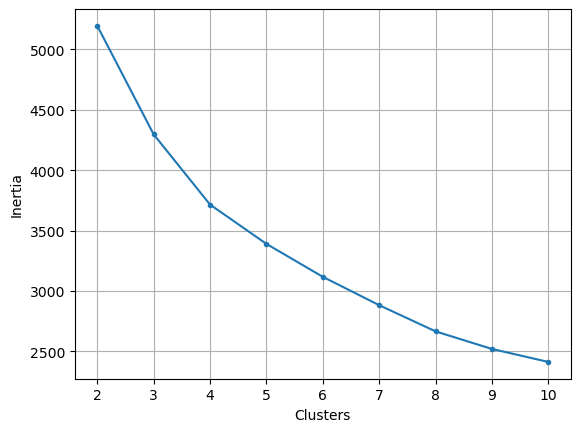

In [70]:
# Display Inertia
labels = ["Clusters", "Inertia"]
cluster.display_plot("inertia",2,11,labels)

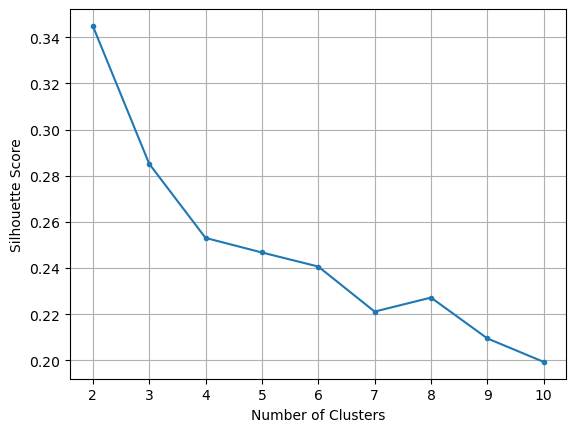

In [71]:
# Display Silhouette score
labels = ["Number of Clusters", "Silhouette Score"]
cluster.display_plot("silhouette",2,11,labels)

- Based on the results of `inertia` and `silhouette score` i think the `Best kmean cluster` is `3` it has low "elbow" inertia meaning the lowest amongst the clusters that has significant change in inertia and 2nd highest Silhouette score


## Kmeans Cluster

In [72]:
# Instantiate Kmeans with best n_Cluster
cluster.inst_cluster(3,cleaned_df)

,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,cluster
54,29,3,5,70,3.176,10.754,1.0,19.9,2
747,35,1,13,42,0.769,6.623,0.0,17.6,1
477,33,1,8,27,0.777,0.789,0.0,5.8,1
773,43,1,11,37,0.180,0.301,0.0,1.3,1
605,39,1,16,57,1.559,9.499,0.0,19.4,0


### Cluster Visualization

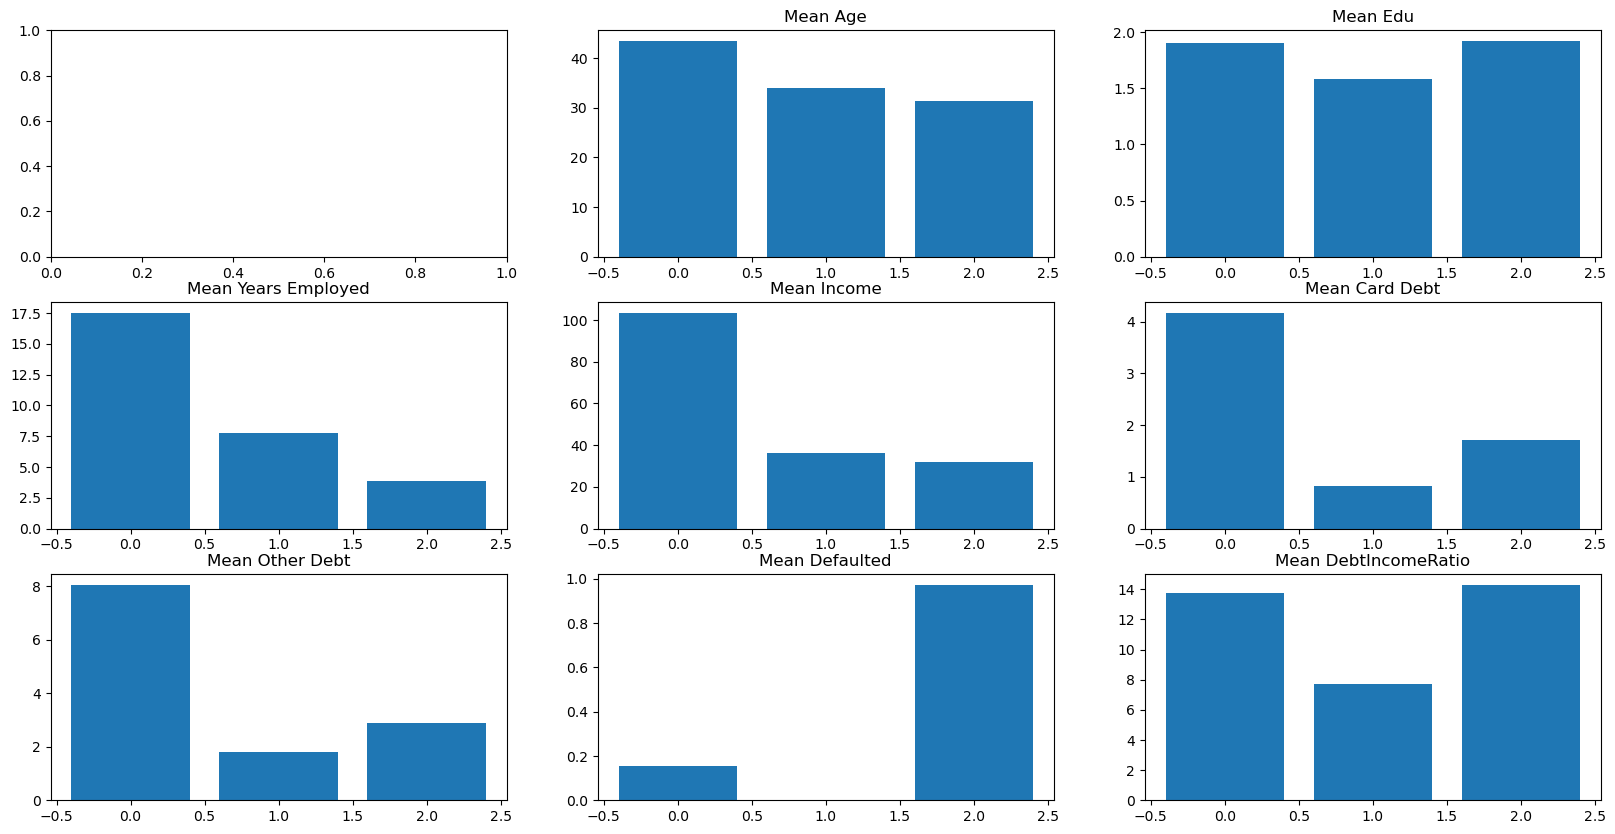

In [73]:
# Display Plot to analyse Clusters
cluster.display_cluster(3,3)

## Cluster Analysis

- Diving in this Custormer clustering analysis with **`Banking business perspective`** and with a **`Stakeholder Question`** of *`Can we find a group of target customers that we can offer more business with?`* like *Credit Card balance transfer promotion* , *Mortgage refinance*, *Life Insurance*, *Auto loans*, etc.

- Cluster 0:
    - Cluster 0 are the oldest group, highly educated and have many years of workforce experience, They make the most amount of income, However, They also carry the most amount of Card debt and Other debt perhaps this is because most of them are homeowners and still paying off their mortgage hense the high debt to income ratio.
    - These customers are good candidate for Mortgage refinance, Life Insurance, and Travel / Business credit cards ,Investment CDs.

- Cluster 1:
    - This group are little younger than cluster 0 with some level of Education and some workforce experience working minimum wage and barely have any loan history hense why they have the lowest DebtIncomeRatio amungst the clusters, this group live within their means and frugal but spend their money wisely.
    - These customers are good candidate for Used car loan, Grocery/Gas Credit cards or Charge cards, Personal loans , Saving accounts.

- Cluster 2:
    - Finally, the last group cluster. This group is the youngest group with high education, Young Professionals with Masters/Doctorate degree which may explain why they have the lowest years Employed and Highest DebtIncomeRatio. These customers may have the lowest income but they have a lot of potential to significantly increase their income as they gain more experience in their respective field.
    - These group of customers are good candidate for Student loan refinance, Mortgage loans, New car loans, Restaurant/Travel Credit cards, and Investments.

## Cluster Visuals using Scatter plot

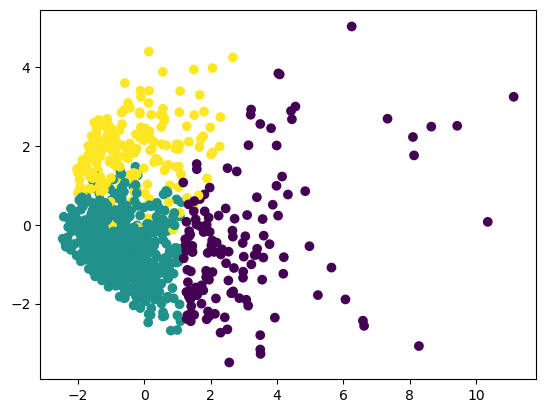

In [74]:
cluster.display_scatter()